In [ ]:
import ImageLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
from scipy.special import binom
import os


class JupyterLauncher:
    cwd: str
    conda_exists: bool

    def __init__(self):
        self.get_cwd()
        self.create_conda_env()
        self.launch_notebook()

    def get_cwd(self):
        self.cwd = os.getcwd()

    def create_conda_env(self):
        for _, val in os.environ.items():
            if 'conda' in val.lower():
                self.conda_exists = True
                print('conda found on system')
                break
            else:
                print('conda not found on system, please install and rerun')

        if self.conda_exists:
            os.system('conda env create --file envname.yml')
            os.system('conda activate lymphoma_classifier')

    def launch_notebook(self):
        os.system(f'cd {self.cwd}')
        os.system('jupyter notebook ExploratoryDataAnalysis.ipynb')

In [15]:
from ImageLoader import ImageLoader
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
from scipy.special import binom
from typing import List

class ExploratoryDataAnalysis:

    def __init__(self, image_data: pd.DataFrame):
        self.image_data = image_data

        cancer_types = ['CLL', 'FL', 'MCL']
        label_decoder = {enum: cancer_type for (enum, cancer_type) in enumerate(cancer_types)}

        self.type_series = self.image_data['cancer_type'].map(label_decoder)
        self.image_series = self.image_data['img_array']
        self.cancer_types = list(self.type_series.unique())

    def cancer_type_counts(self):
        """print the value counts for each of the cancer subtypes and display the values on a chart"""

        """print the value counts"""
        print(f'The cancer type value counts are:\n{self.type_series.value_counts()}')

        """create bar chart with cancer type as x, counts as y"""
        cancer_types = self.type_series.value_counts().index
        cancer_counts = self.type_series.value_counts().values
        fig, ax = plt.subplots(1, 1, figsize=(10, 5))
        bar_chart = ax.bar(x=cancer_types, height=cancer_counts)

        """calculate cancer type percentages and print them atop each bar"""
        type_percents = [round(i/len(self.type_series), 2) for i in cancer_counts]
        for i, bar in enumerate(bar_chart):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2., height,
                    type_percents[i],
                    ha='center', va='bottom')

        plt.title('Count by cancer type with percentages as text')
        plt.show()


    def get_image_dims(self):
        """get the image-wise dimensions"""

        img_heights, img_widths = set(), set()

        for img in self.image_series:
            height, width = img.shape[0], img.shape[1]
            img_heights.add(height)
            img_widths.add(width)

        print('Image heights are: ', img_heights)
        print('Image widths are: ', img_widths)

        #
        # # widths and heights if input is torchvision dataset
        # else:
        #
        #     for i in range(len(data)):
        #         width, height = data[i][0].shape[2], data[i][0].shape[1]
        #         img_heights.append(height)
        #         img_widths.append(width)
        #
        #     # cast to set to eliminate duplicates
        #     img_heights = set(img_heights)
        #     img_widths = set(img_widths)
        #
        #     print('Image heights are: ', img_heights)
        #     print('Image widths are: ', img_widths)
        #
        # if not set_:
        #     img_heights = min(img_heights)
        #     img_widths = min(img_widths)
        #
        # return img_heights, img_widths


    def get_intensity_range(self):
        """get the pixel-wise intensity mins and maxs"""

        maxs = [np.amax(img) for img in self.image_series]
        mins = [np.amin(img) for img in self.image_series]

        print(f'The highest intesity in the range: {max(maxs)}')
        print(f'The lowest intesity in the range: {min(mins)}')

        # # intensities if input is torchvision dataset
        # else:
        #     for i in range(len(data)):
        #         maxs.append(torch.max(data[i][0]))
        #         mins.append(torch.min(data[i][0]))


    def get_random_image(self, figsize=(30, 10)):
        """get a random image of each of the cancer types"""

        rand_imgs = []

        for _, cancer_type in enumerate(self.cancer_types):
            index_by_type = self.type_series[self.type_series == cancer_type].index
            rand_idx = random.choice(index_by_type)
            rand_imgs.append(self.image_data.at[rand_idx, 'img_array'])

        fig, axs = plt.subplots(1, len(rand_imgs), figsize=figsize)
        for i, img in enumerate(rand_imgs):
            axs[i].set_title(f'Cancer type: {self.cancer_types[i]}')
            axs[i].imshow(img)
        plt.show()


    def plot_prob_transforms(self, p_values: List[float], n_poss_transforms: int, figsize=(30, 10)):
        """plot the probabilities that n transformations are applied to a given image based on the number of possible
            transformations and the probability p of the transformer"""

        prob_dict = {}
        num_p_values = len(p_values)

        """define probabilities of specific number of transforms"""
        for p in p_values:
            p_comp = 1-p
            prob_dict[p] = {i: p**i * p_comp**(n_poss_transforms-i) * binom(n_poss_transforms, i)
                            for i in range(n_poss_transforms+1)}

        """create subplots for however many p-values input"""
        fig, axs = plt.subplots(1, num_p_values, figsize=figsize)
        fig.suptitle('Probability of a given number of transforms with varying p values')
        sns.set_style('dark')

        """define dual axes dict and make dual x axes for pareto"""
        axes = {i: axs for (i, axs) in enumerate(axs)}
        for i, ax in enumerate(axs):
            axes[i+num_p_values] = ax.twinx()
            axes[i+num_p_values].set_ylim(0, 1.05)

        """first create bar plot for probability values and then pareto line plot on top"""
        for i, p in enumerate(p_values):
            keys = list(prob_dict[p].keys())
            values = [prob_dict[p][k] for k in keys]
            sns.barplot(x=keys, y=values, ax=axes[i])
            axes[i].set_title(f'p={p}')

            cumulative_values = np.cumsum(values)
            sns.lineplot(x=keys, y=cumulative_values, ax=axes[i+num_p_values], color='black',
                         marker='o', markersize=10, linewidth=3)
        plt.show()

In [16]:
import os
import pickle

if 'image_loader.obj' in os.listdir(os.getcwd()):
    with open('image_loader.obj', 'rb') as f:
        image_data = pickle.load(f)

    eda = ExploratoryDataAnalysis(image_data)

else:
    image_data = ImageLoader('./Images')
    eda = ExploratoryDataAnalysis(image_data)

In [17]:
eda.type_series

0      CLL
1      CLL
2      CLL
3      CLL
4      CLL
      ... 
369    MCL
370    MCL
371    MCL
372    MCL
373    MCL
Name: cancer_type, Length: 374, dtype: object

The cancer type value counts are:
FL     139
MCL    122
CLL    113
Name: cancer_type, dtype: int64


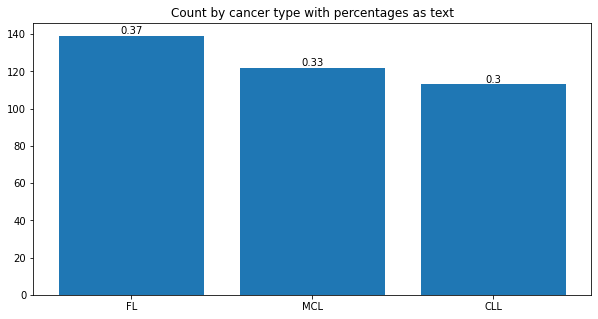

In [18]:
eda.cancer_type_counts()

In [19]:
eda.get_image_dims()

Image heights are:  {1040}
Image widths are:  {1388}


In [20]:
eda.get_intensity_range()

The highest intesity in the range: 255
The lowest intesity in the range: 2


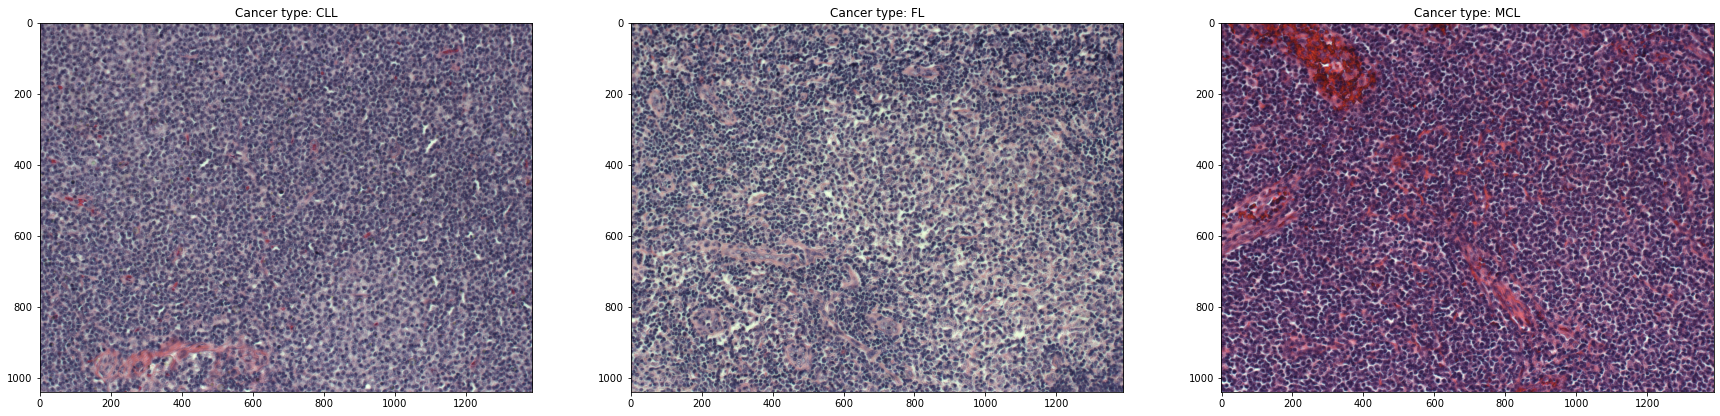

In [21]:
eda.get_random_image()

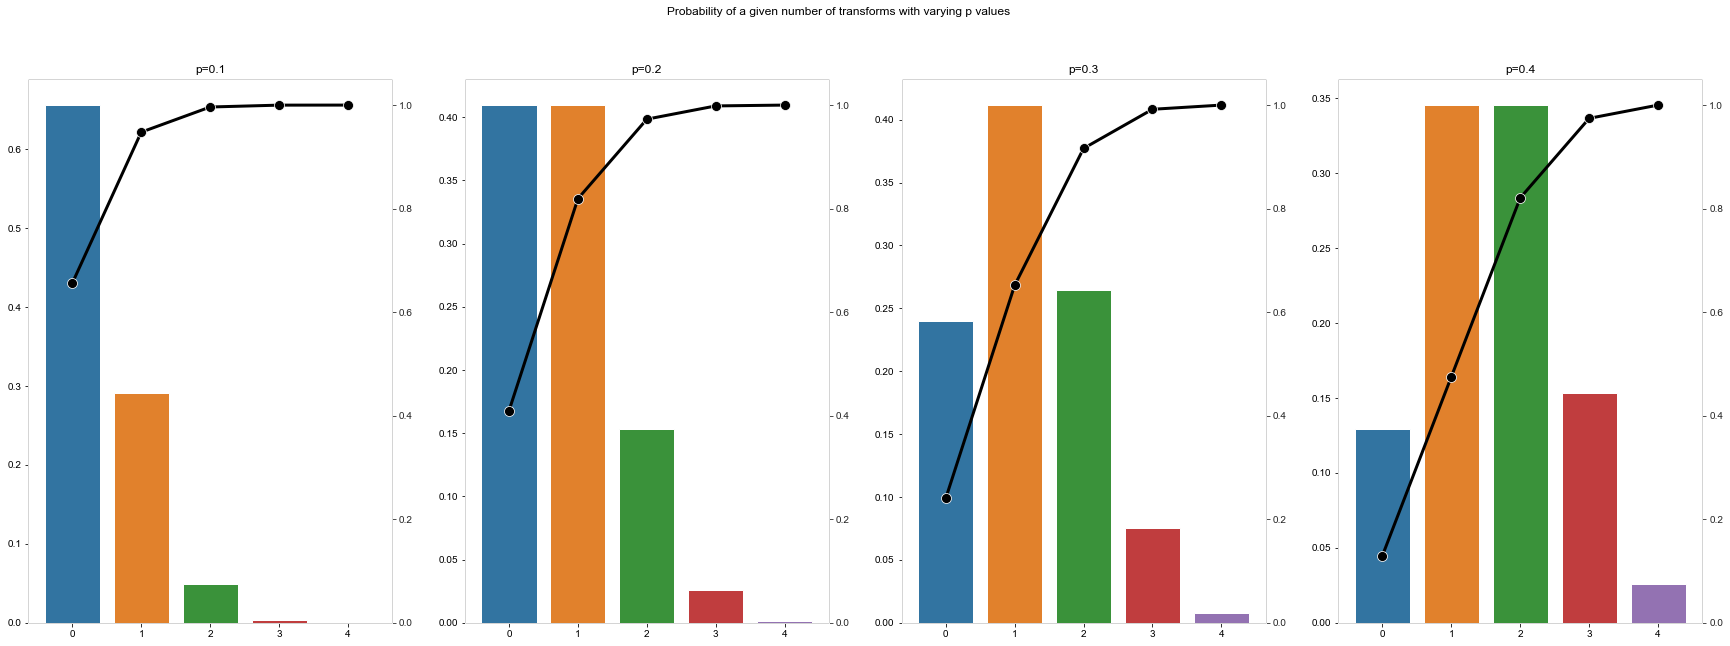

In [24]:
eda.plot_prob_transforms(p_values=[0.1,0.2,0.3,0.4], n_poss_transforms=4)

In [10]:
import pip
pip.main(['install', 'torch==1.6.0+cu101', 'torchvision==0.7.0+cu101', '--user', '-f', 'https://download.pytorch.org/whl/torch_stable.html'])

Looking in links: https://download.pytorch.org/whl/torch_stable.html


Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


  Using cached https://download.pytorch.org/whl/cu101/torch-1.6.0%2Bcu101-cp36-cp36m-win_amd64.whl (1021.6 MB)
  Using cached https://download.pytorch.org/whl/cu101/torchvision-0.7.0%2Bcu101-cp36-cp36m-win_amd64.whl (1.1 MB)


ERROR: torch 1.6.0+cu101 requires future, which is not installed.
ERROR: torchaudio 0.9.0 has requirement torch==1.9.0, but you'll have torch 1.6.0+cu101 which is incompatible.


  Attempting uninstall: torch
    Found existing installation: torch 1.9.0
    Can't uninstall 'torch'. No files were found to uninstall.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.0
    Uninstalling torchvision-0.10.0:
      Successfully uninstalled torchvision-0.10.0


0